Isolation Forest is an unsupervised machine learning algorithm for anomaly detection
Building on isolation tree 

In [4]:
# Imports
!pip3 install -U ucimlrepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from ucimlrepo import fetch_ucirepo

  Using cached ucimlrepo-0.0.7-py3-none-any.whl (8.0 kB)


Dataset
We load our data directly from the UCI machine learning repository. We are using the Air Quality dataset (CC BY 4.0), which contains 9,358 instances of air quality measurements from a sensor in an Italian city. In the context of this dataset, an anomaly can be considered a sensor reading that indicates unusually high levels of pollution.

In [5]:
# Fetch dataset from UCI repository
air_quality = fetch_ucirepo(id=360)

Data cleaning

In [6]:
# Convert to DataFrame
data = air_quality.data.features

# Select features
features = data[['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']]

# Drop rows with missing values (-200)
features = features.replace(-200, np.nan)
features = features.dropna()

print(features.shape)
features.head()

(6941, 4)


,CO(GT),C6H6(GT),NOx(GT),NO2(GT)
0,2.6,11.9,166.0,113.0
1,2.0,9.4,103.0,92.0
2,2.2,9.0,131.0,114.0
3,2.2,9.2,172.0,122.0
4,1.6,6.5,131.0,116.0


Define the training parameters
The last thing to do is define the parameters used to train the Isolation Forest. In this case, we’ll use the three values below: 

n_estimators is the number of Isolation Trees used in the ensemble. A value of 100 is used in the Isolation Forest paper. Through experimentation, the researchers found this to produce good results over a variety of datasets. 
contamination is the percentage of data points we expect to be anomalies. 
sample_size is the number of instances used to train each Isolation Tree. A value of 256 is commonly used as it allows us to avoid using a maximum tree size stopping criteria. This is because we can expect reasonable maximum tree sizes of log(256) = 8.

In [7]:
# Parameters
n_estimators = 100  # Number of trees
contamination = 0.01  # Expected proportion of anomalies
sample_size = 256  # Number of samples used to train each tree

Train the Isolation Forest

In [8]:
# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            max_samples=sample_size,
                            random_state=42)
iso_forest.fit(features)

IsolationForest(contamination=0.01, max_samples=256, random_state=42)

Calculate anomaly scores
The trained model has two useful functions: 

decision_function will calculate the anomaly score in a similar way to what we discussed in the theory section. 
predict will provide a binary label based on the contamination values. In our case, the 1% of instances with the worst anomaly scores will be given a value of -1. The other instances are given a value of 1.

In [9]:
# Calculate anomaly scores and classify anomalies
data = data.loc[features.index].copy()
data['anomaly_score'] = iso_forest.decision_function(features)
data['anomaly'] = iso_forest.predict(features)

data['anomaly'].value_counts()

 1    6871
-1      70
Name: anomaly, dtype: int64

We can go further and visualise all the anomaly scores. We do this using the code below:

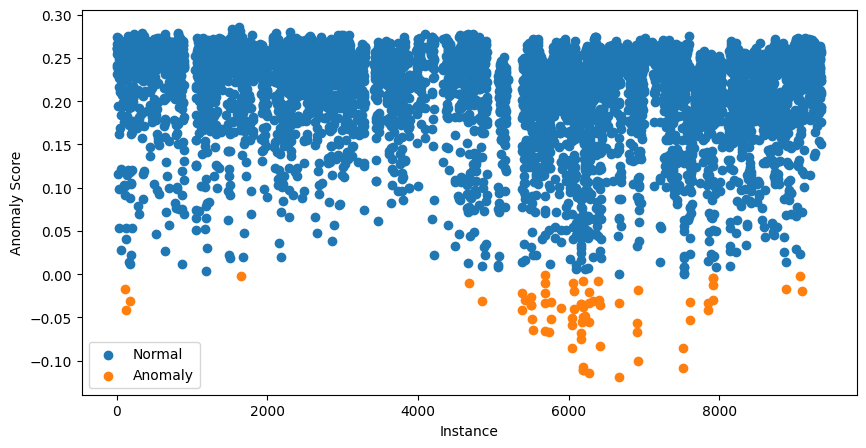

In [10]:
# Visualization of the results
plt.figure(figsize=(10, 5))

# Plot normal instances
normal = data[data['anomaly'] == 1]
plt.scatter(normal.index, normal['anomaly_score'], label='Normal')

# Plot anomalies
anomalies = data[data['anomaly'] == -1]
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly')
plt.xlabel("Instance")
plt.ylabel("Anomaly Score")
plt.legend()
plt.show()

Further analysis

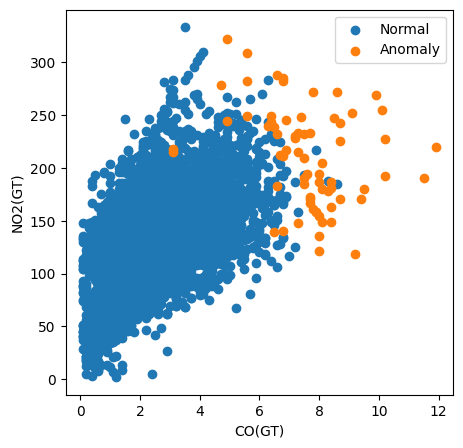

In [11]:
# Visualization of the results
plt.figure(figsize=(5, 5))

# Plot non-anomalies then anomalies
plt.scatter(normal['CO(GT)'], normal['NO2(GT)'], label='Normal')
plt.scatter(anomalies['CO(GT)'], anomalies['NO2(GT)'], label='Anomaly')
plt.xlabel("CO(GT)")
plt.ylabel("NO2(GT)")
plt.legend()
plt.show()